In [223]:
import os.path

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from imblearn.pipeline import Pipeline as imbPipeline

# Input the data

## load dataset

In [174]:
file_path = Path('../data/Diabetes_EDA_Kaggle/diabetes_prediction_dataset.csv')

if not os.path.exists(file_path):
    raise FileExistsError(f"Directory {file_path} does not exist")

df = pd.read_csv(file_path)

df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


## handling duplicates

In [175]:
duplicate_rows_data = df[df.duplicated()]
print("quantity of duplicate rows: ", duplicate_rows_data.shape)

quantity of duplicate rows:  (3854, 9)


## delete duplicates

In [176]:
df = df.drop_duplicates()
df.shape

(96146, 9)

## Uniqueness

In [177]:
for column in df.columns:
    unique_value = len(df[column].unique())
    print(f"{column}: {unique_value} quantity unique value")

gender: 3 quantity unique value
age: 102 quantity unique value
hypertension: 2 quantity unique value
heart_disease: 2 quantity unique value
smoking_history: 6 quantity unique value
bmi: 4247 quantity unique value
HbA1c_level: 18 quantity unique value
blood_glucose_level: 18 quantity unique value
diabetes: 2 quantity unique value


## missing values

In [178]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

## Remove Unneccessary value

In [179]:
df = df[df['gender'] != 'Other']
df.shape

(96128, 9)

## Describe the Data

In [180]:
df.describe().style.format('{:.2f}')

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96128.00,96128.00,96128.00,96128.00,96128.00,96128.00,96128.00
mean,41.80,0.08,0.04,27.32,5.53,138.22,0.09
std,22.46,0.27,0.20,6.77,1.07,40.91,0.28
min,0.08,0.00,0.00,10.01,3.50,80.00,0.00
25%,24.00,0.00,0.00,23.40,4.80,100.00,0.00
50%,43.00,0.00,0.00,27.32,5.80,140.00,0.00
75%,59.00,0.00,0.00,29.86,6.20,159.00,0.00
max,80.00,1.00,1.00,95.69,9.00,300.00,1.00


# Visualisation

## Histogram for age

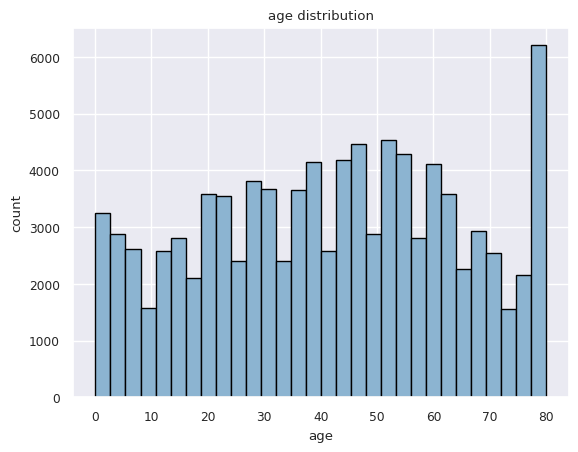

In [181]:
plt.hist(df['age'], bins=30, edgecolor='black')
# bins=30 in plt.hist(...) means that the histogram will be split into 30 "bins" (columns).
# Each bin is a range of age values, for example:
# 1 bin: 0 to 3 years,
# 2 bin: 3 to 6 years,ng
plt.title('age distribution')
plt.xlabel('age')
plt.ylabel('count')
plt.show()

## Bar plot for gender

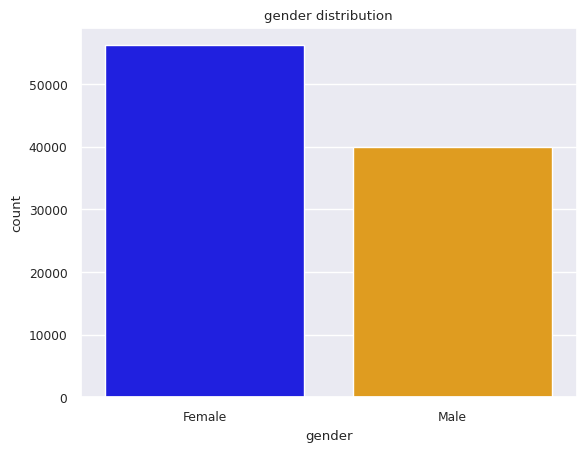

In [182]:
sns.countplot(x='gender', data=df, hue='gender', palette=['blue', 'orange'])
plt.title('gender distribution')
plt.show()

## Distribution plot for BMI

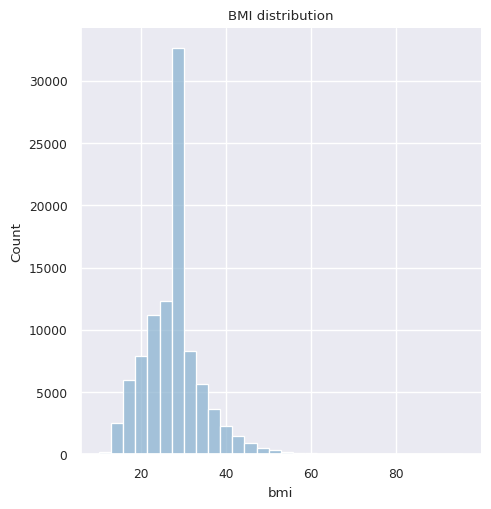

In [183]:
sns.displot(df['bmi'], bins=30)  # there is KDE here (smooth density curve)
plt.title('BMI distribution')
plt.show()

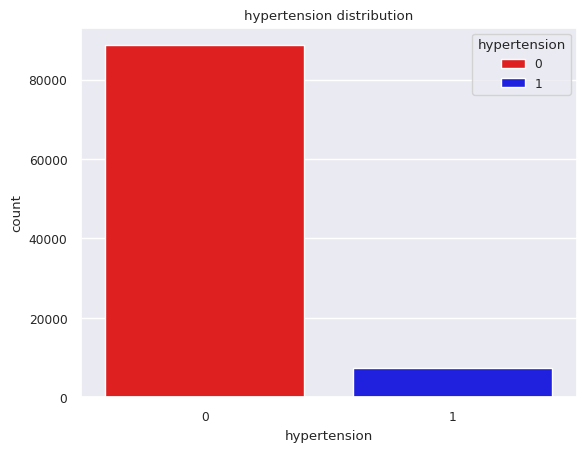

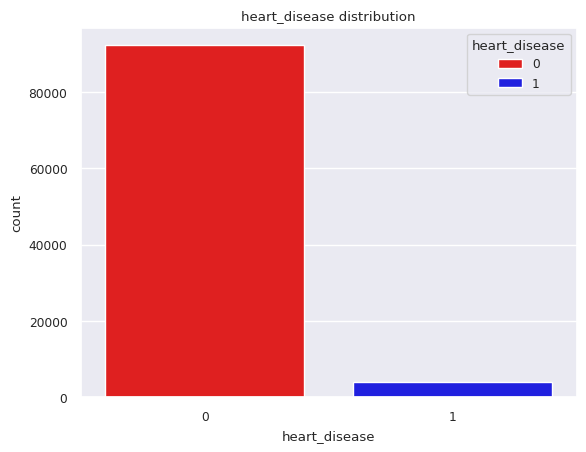

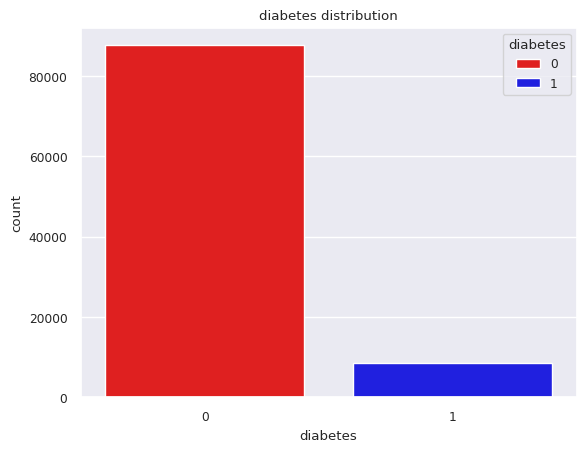

In [184]:
for col in ['hypertension', 'heart_disease', 'diabetes']:
    sns.countplot(x=col, data=df, hue=col, palette=['red', 'blue'])
    plt.title(f'{col} distribution')
    plt.show()

## Count plot for smoking history

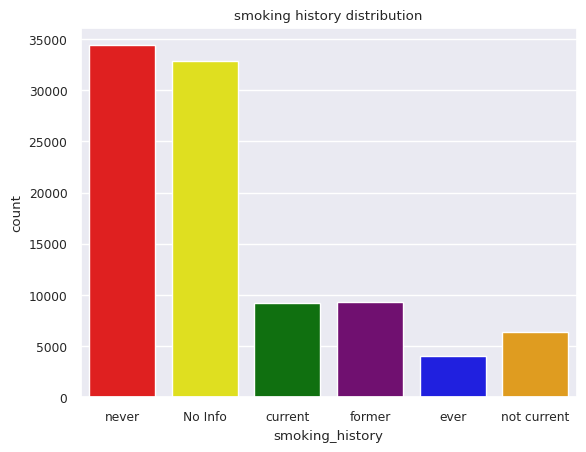

In [185]:
sns.countplot(x='smoking_history', data=df, hue='smoking_history',
              palette=['red', 'yellow', 'green', 'purple', 'blue', 'orange'])
plt.title('smoking history distribution')
plt.show()

## Boxplot BMI vs Diabetes classification

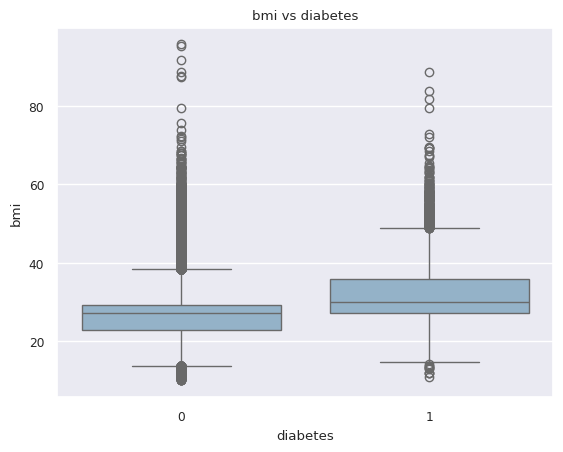

In [186]:
sns.boxplot(x='diabetes', y='bmi',
            data=df)  # graph shows how BMI (body mass index) is related to the presence of diabetes
plt.title('bmi vs diabetes')
plt.show()

## Boxplot Age vs Diabetes classification

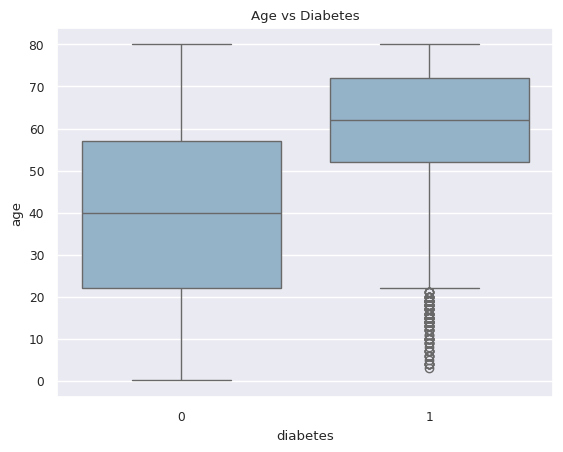

In [187]:
sns.boxplot(x='diabetes', y='age', data=df)
plt.title('Age vs Diabetes')
plt.show()

## Count plot of gender vs diabetes

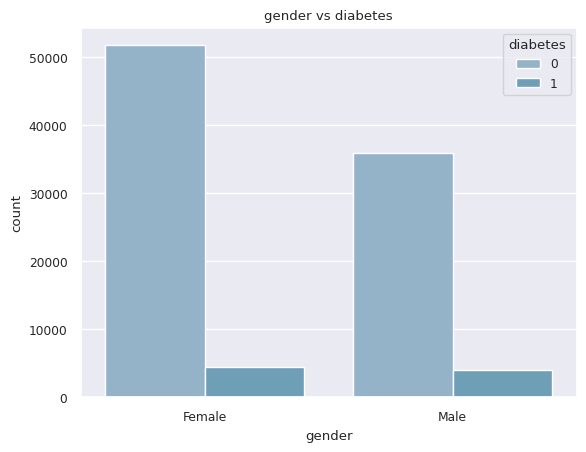

In [188]:
sns.countplot(x='gender', hue='diabetes', data=df)
plt.title('gender vs diabetes')
plt.show()

# Boxplot HbA1c level vs Diabetes classification

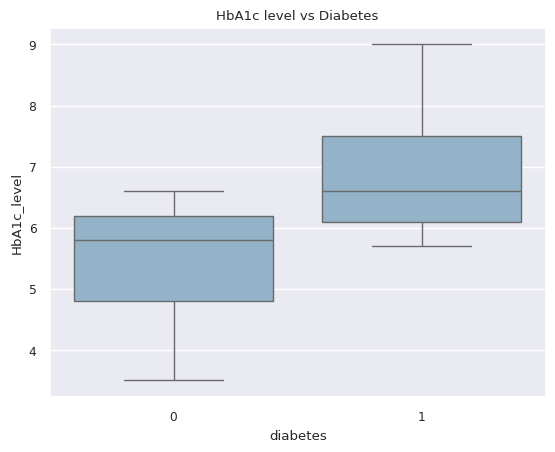

In [189]:
sns.boxplot(x='diabetes', y="HbA1c_level", data=df)
plt.title('HbA1c level vs Diabetes')
plt.show()

## Boxplot blood glucose level vs Diabetes classification

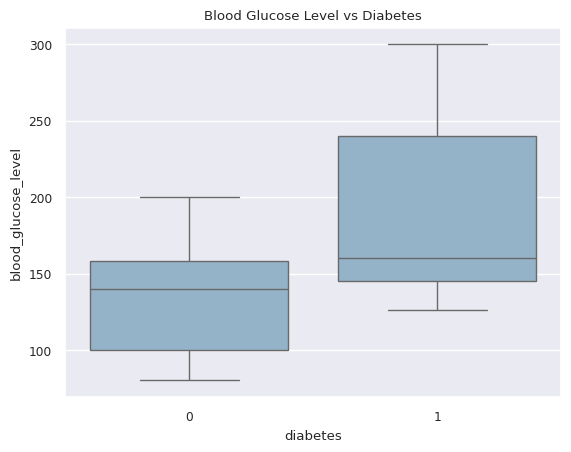

In [190]:
sns.boxplot(x='diabetes', y='blood_glucose_level', data=df)
plt.title('Blood Glucose Level vs Diabetes')
plt.show()

## Pair plot for numeric features

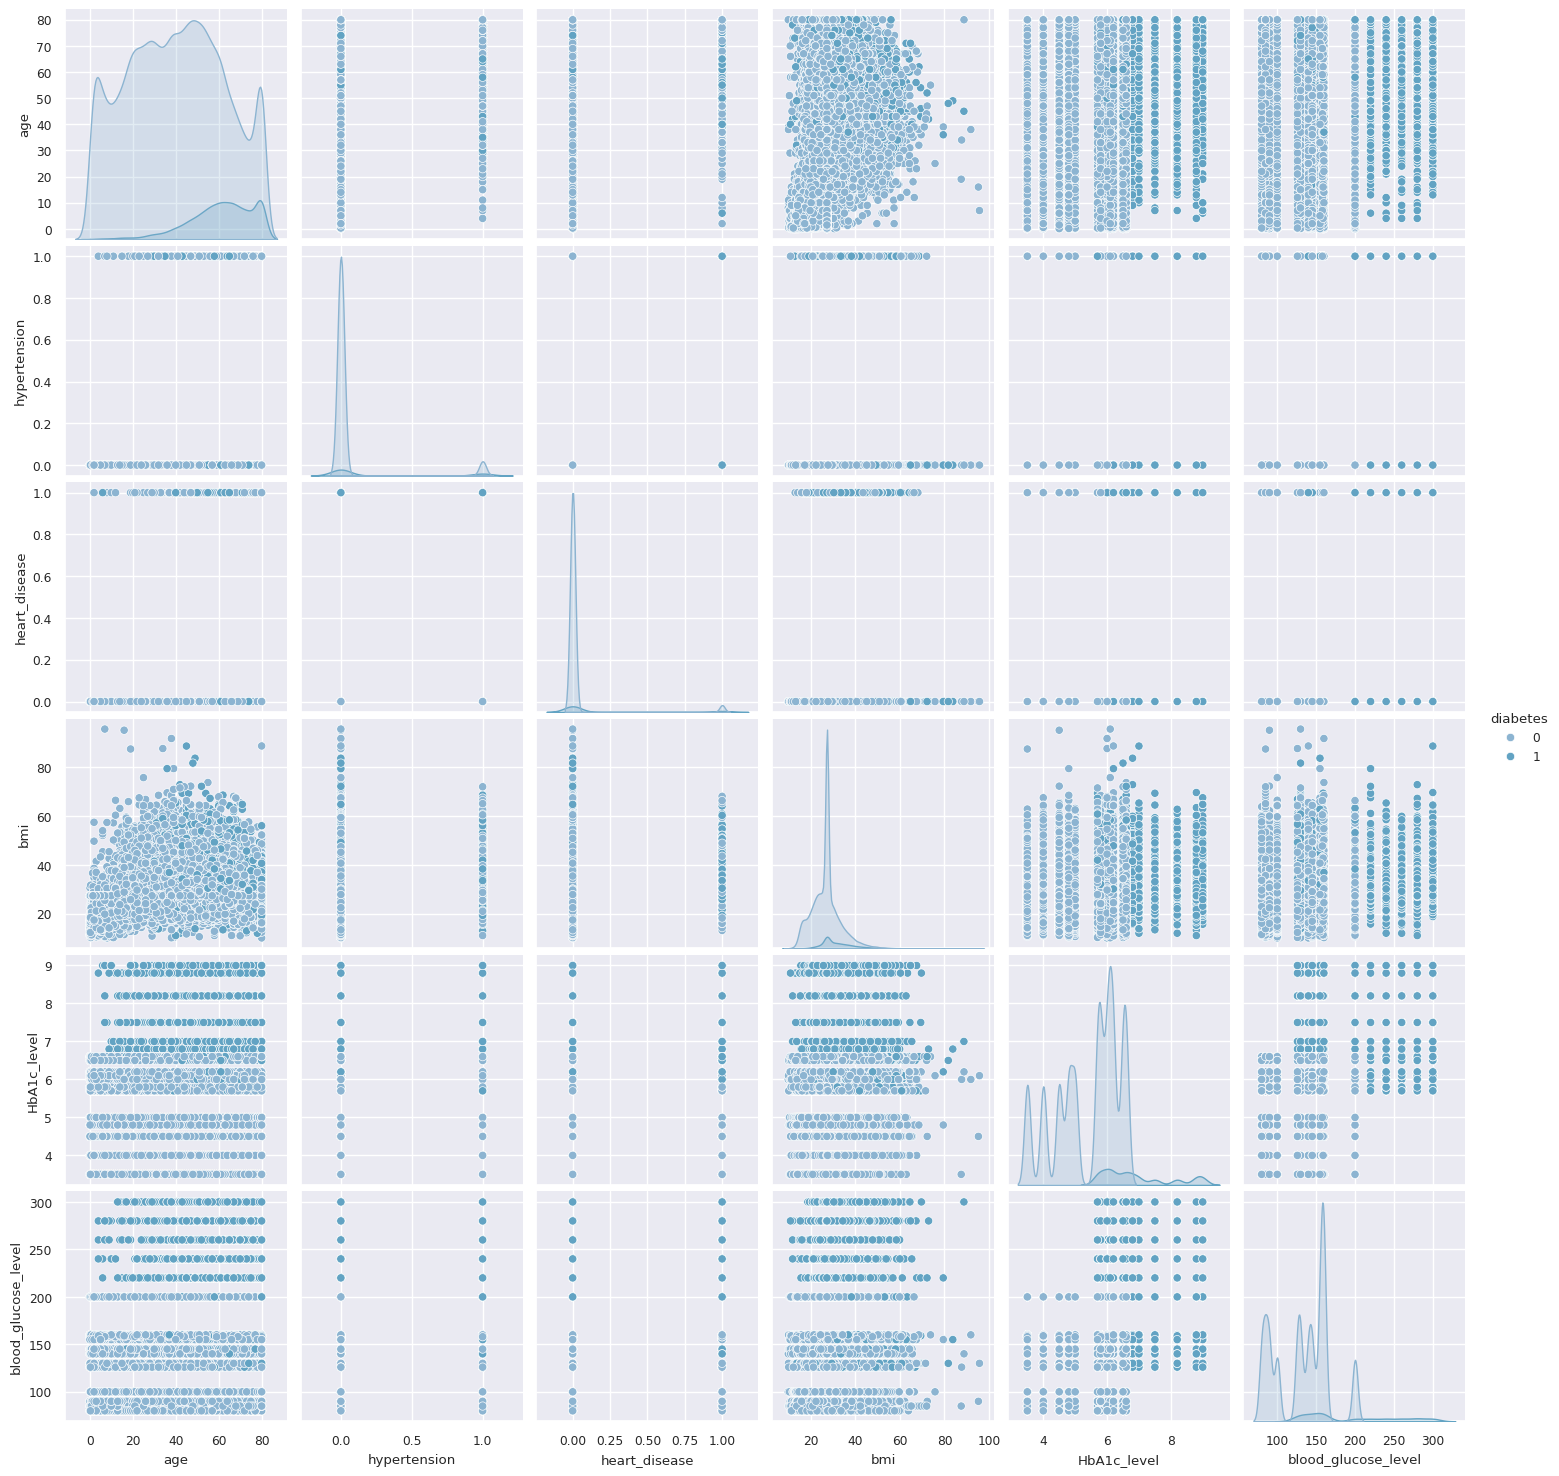

In [191]:
sns.pairplot(df, hue='diabetes')
plt.show()
# for example:
# 🔴 — diabetes positive (1),
# 🔵 — diabetes negative (0).
# It is clear which signs correlate with each other.

## Scatterplot Age vs BMI colored by Diabetes classification

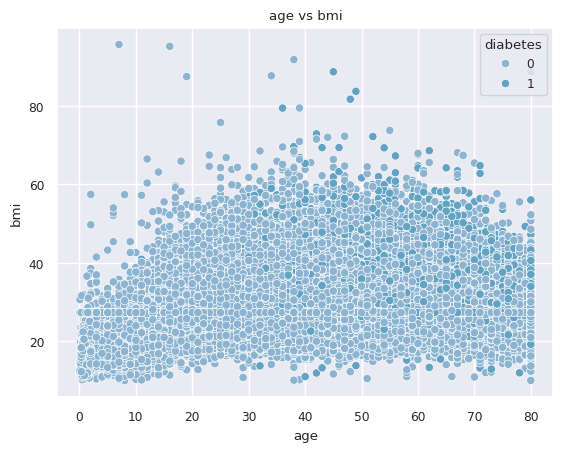

In [192]:
sns.scatterplot(x='age', y='bmi', hue='diabetes', data=df)
plt.title('age vs bmi')
plt.show()

## Violin plot of BMI against diabetes classification split by gender

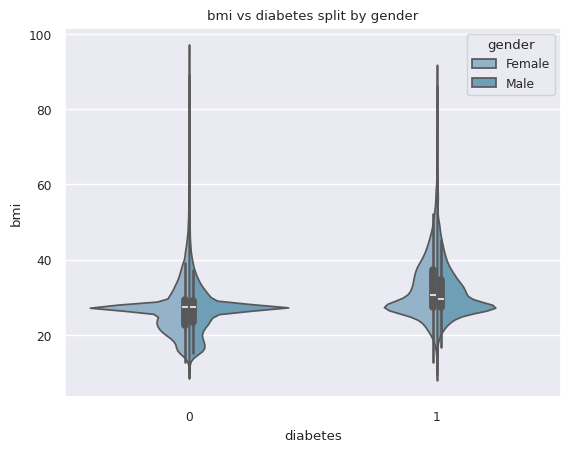

In [193]:
sns.violinplot(x='diabetes', y='bmi', hue='gender', split=True, data=df)
plt.title('bmi vs diabetes split by gender')
plt.show()
# violinplot shows the distribution of BMI in people with and without diabetes, divided by gender.
# The small vertical bar in the center is the median (the average BMI for the group).
# The thick gray bar (box) is the range where 50% of the data is (from the 25th to the 75th percentile).
# The thin lines (whiskers) are the extreme values of the data, excluding outliers.

# how to read part of violin:
# Width = how many people have that BMI.
# The wider the part, the more people have that value.
# Narrow parts are rare values.

##  Interaction between gender, BMI and diabetes

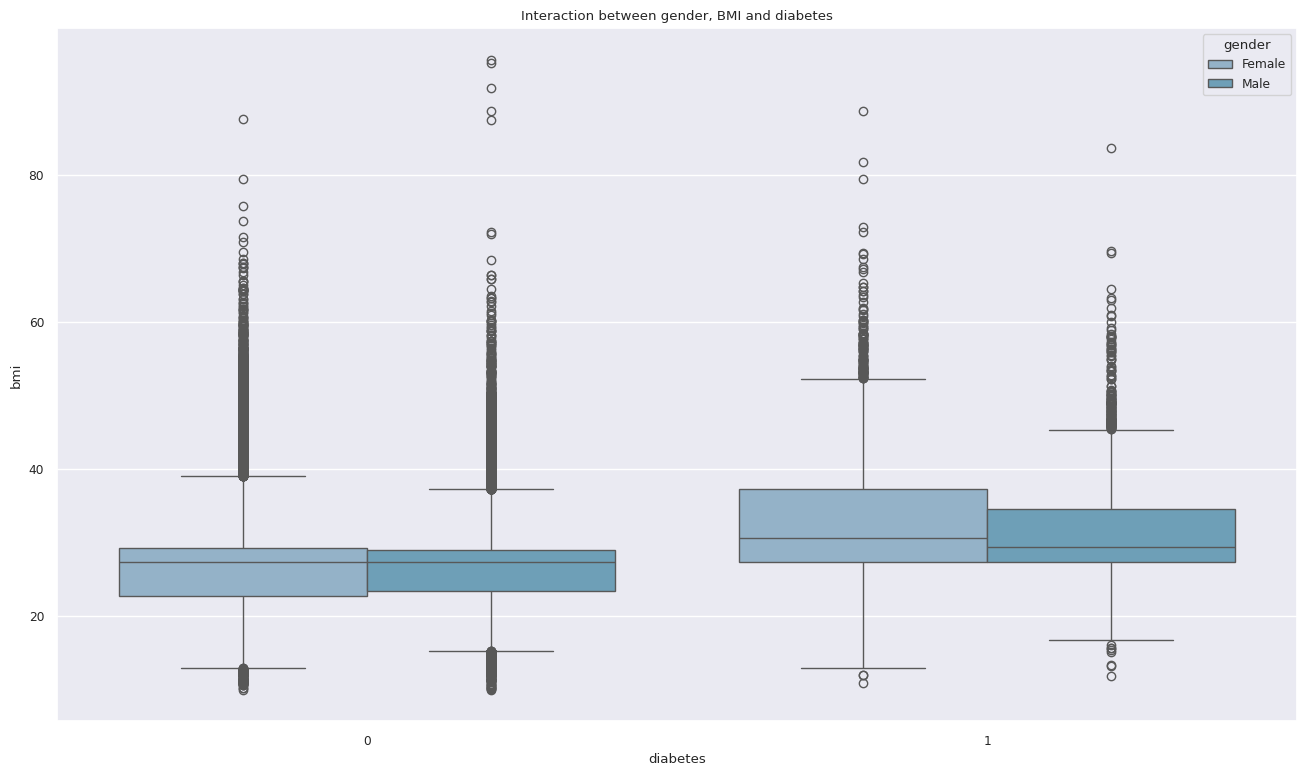

In [194]:
plt.figure(figsize=(16, 9))
sns.boxplot(x='diabetes', y='bmi', hue='gender', data=df)
plt.title('Interaction between gender, BMI and diabetes')
plt.show()

## Interaction between gender, Age and diabetes

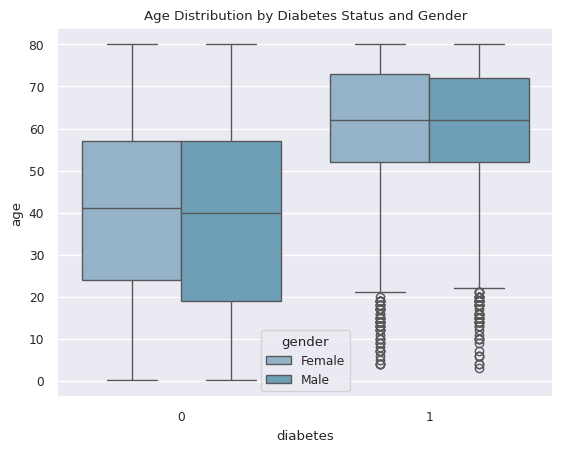

In [195]:
sns.boxplot(x='diabetes', y='age', hue='gender', data=df)
plt.title('Age Distribution by Diabetes Status and Gender')
plt.show()

# Data preparation

In [196]:
def recategorize_smoking(smoking_status):
    match smoking_status:
        case 'never' | 'No Info':
            return 'non-smoker'
        case 'current':
            return 'current'
        case 'ever' | 'former' | 'not current':
            return 'pass_smoker'
        case _:
            raise ValueError(f"Unexpected smoking status: {smoking_status}")


df['smoking_history'] = df['smoking_history'].apply(recategorize_smoking)
# The .apply() method in Pandas applies to each element of a column or row, executing the specified function for each value.
# apply() will call the recategorize_smoking function for each value in the column and return the result in a new column.
# When you write .apply(recategorize_smoking), you are not calling the function directly, but passing a reference to the function so that it can be applied to all in the column.

In [197]:
data = df.copy()

## Encoding

In [198]:
# perform_one_hot_encoding - for analysis, graphics
# OneHotEncoder - In Pipeline, for ML models, cross-validation
def perform_one_hot_encoding(data_frame, column_name):
    dummmies = pd.get_dummies(data_frame[column_name], prefix=column_name)
    # pd.get_dummies(df[column_name]) is a pandas method that turns categorical values in column_name into a set of binary (0 or 1) columns.
    # prefix=column_name adds a prefix to the names of the new columns so that they are identifiable (e.g. if the column is called gender, the new columns will be named gender_male, gender_female)
    return pd.concat([data_frame.drop(column_name, axis=1), dummmies], axis=1)


# pd.concat([df.drop(column_name, axis=1), dummies], axis=1) — concatenates the dataframe without the original column with new binary columns (dummy variables), adding them horizontally (axis=1).

data = perform_one_hot_encoding(data, 'gender')

data = perform_one_hot_encoding(data, 'smoking_history')

## Correlation Matrix

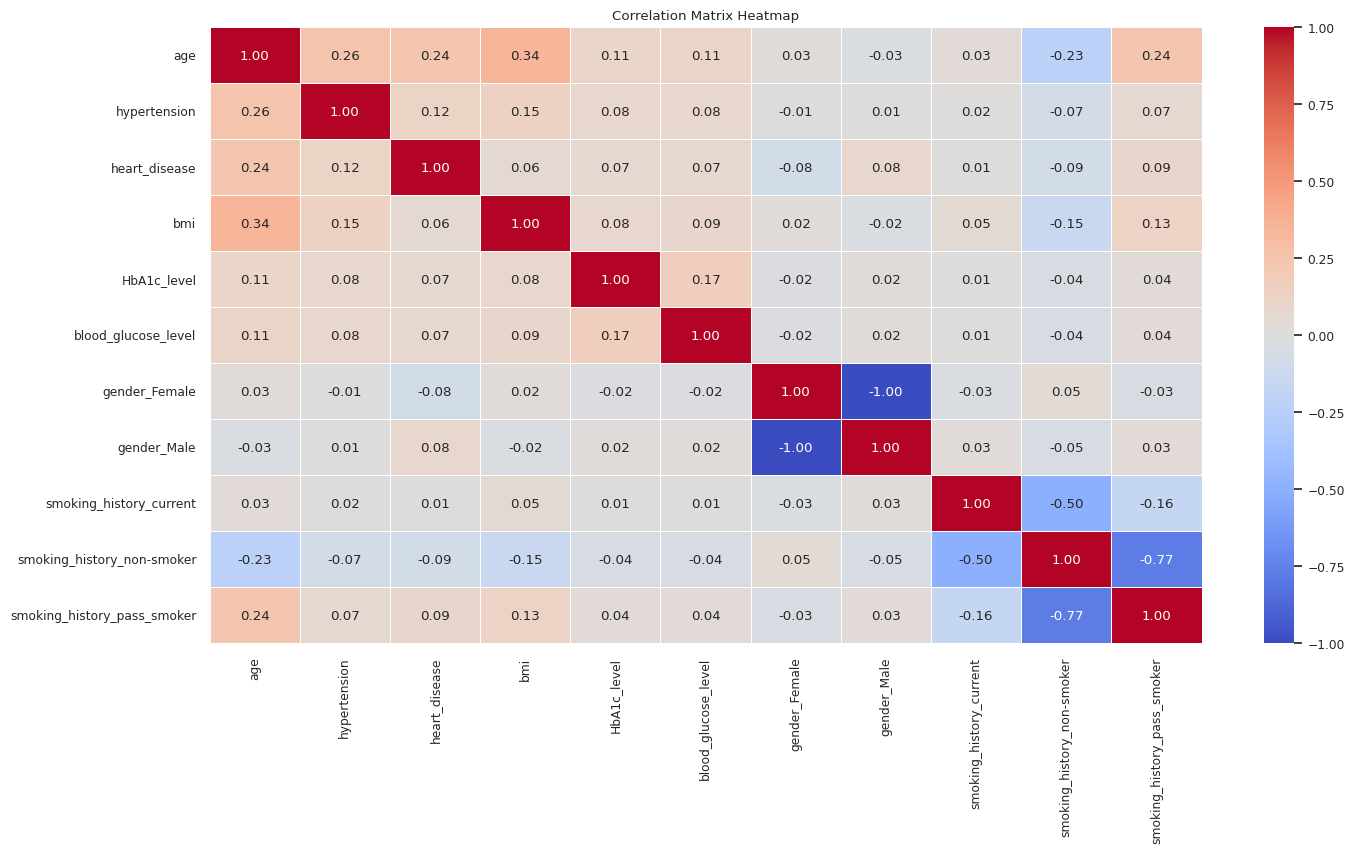

In [199]:
# Compute the correlation matrix

#Graph I.
plt.figure(figsize=(16, 8))
sns.heatmap(data.drop(columns=['diabetes']).corr(), cmap='coolwarm', annot=True, linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()

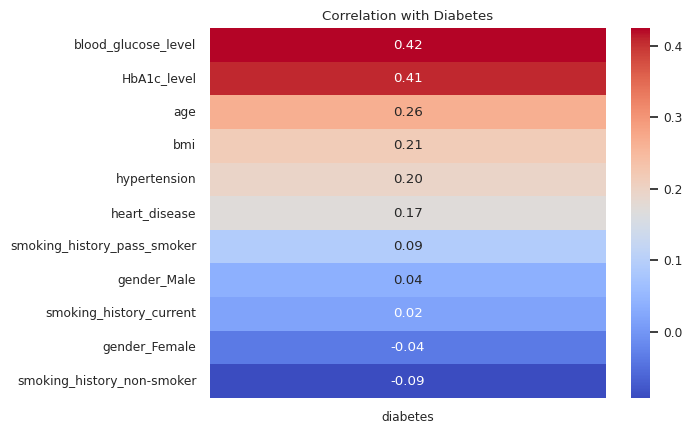

In [200]:
# Graph II
# Create a heatmap of the correlations with the target column
correlation_matrix2 = data.corr()
target_corr = (correlation_matrix2['diabetes'].drop('diabetes'))

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)
sns.set_theme(font_scale=0.8)
sns.set_style('darkgrid')
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap='coolwarm', annot=True, fmt='.2f')
# target_corr_sorted is a Series, and sns.heatmap() expects a table (DataFrame), even if it is a single-column one, so we need to turn the Series into a DataFrame
plt.title('Correlation with Diabetes')
plt.show()

# PREDICTIVE ANALYSIS

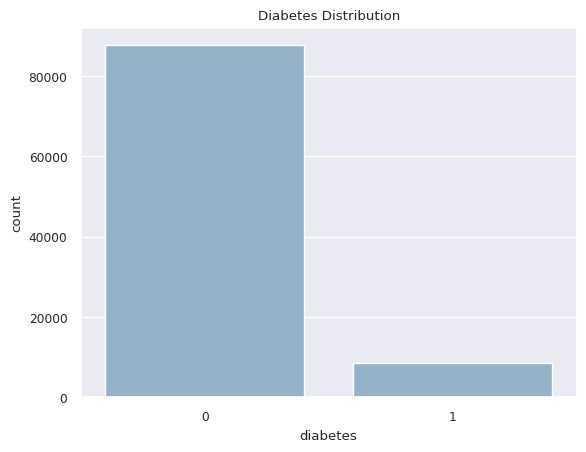

In [201]:
"""
From the EDA ,the dataset is imbalanced (with 9% positive cases for diabetes and 91% negative cases), it's essential to balance the data to ensure that the model doesn't get biased towards the majority class. For this purpose, the Synthetic Minority Over-sampling Technique (SMOTE) is used, which generates synthetic samples for the minority class.
"""
sns.countplot(x='diabetes', data=df)
plt.title('Diabetes Distribution')
plt.show()

In [202]:
# Define resampling
over = SMOTE(sampling_strategy=0.1)
# SMOTE - adds new artificial examples of the rare class (in our case - sick)
# sampling_strategy=0.1 - This means that after SMOTE, the rare class (diabetes) will be 10% of the total. (for example: Was: 950 (healthy) and 50 (sick) and will become: Approximately 105 sick and 950 healthy)
under = RandomUnderSampler(sampling_strategy=0.5)
# RandomUnderSampler - removes examples of the frequent class (healthy) to balance the classes.
# this sounds like: "leave 2 times more healthy than sick". We have 105 sick, so we leave: 105 × 2 = 210 healthy. That is, 750 healthy will be removed randomly.


# Why not just use SMOTE?
# 1. Too much artificial data. 50 real patients, and you want to make 950 - this means that more than 94% will be artificial.
# 2. Not enough diversity in the input data. If there are only 50 real examples, then even SMOTE will not be able to come up with truly diverse new ones.
# 3. Long training and high complexity. Generating a large amount of data requires more resources.

## Define preprocessor

In [203]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(),
         ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'hypertension', 'heart_disease']),
        ('cat', OneHotEncoder(), ['gender', 'smoking_history'])

    ]
)

# Split data into features and target variable
X = df.drop('diabetes', axis=1)
y = df['diabetes']

## Create Pipeline

### RFC

In [209]:
# Create a pipeline that preprocesses the data, resamples data, and then trains a classifier
clf = imbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('over', over),
    ('under', under),
    ('classifier', RandomForestClassifier())
])

In [210]:
# Define the hyperparameters and the values we want to test
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [211]:
# Create Grid Search object
grid_search = GridSearchCV(clf, param_grid, cv=5)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
grid_search.fit(X_train, y_train)

print('Best parameters', grid_search.best_params_)

Best parameters {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}


In [213]:
# max_depth = 10
# This is the maximum depth of the decision tree.
# That is, how many times the tree can "ask questions" to come to a conclusion.
# If the tree is too deep → it can remember the data and overfit.
# If it is too shallow → it will not understand the pattern.
# 10 is the "golden mean".

# min_samples_leaf = 4
# Это значит, что в конце дерева (лист) должно быть минимум 4 примера.
# if you specify 1, then the logic will be based on only 1 person, this is too dangerous - what if it's just a coincidence or a mistake?
# And if min_samples_leaf = 2: Now the tree will say: "I will not make a conclusion (i.e. create a 'leaf') if there is only 1 person in this group. I need at least 2 for me to be sure."
# Why is this?
# 1. This is protection against overfitting - so that the model does not learn from noise or mistakes.
# 2. The higher the value, the rougher and more general the rules will be (the model is more stable, but may lose accuracy).

# min_samples_split = 2
# A tree node (internal "branch") can split if it has at least 2 samples.
# If you set more (for example 10), the tree will split less often.
# Helps control tree growth.
# 2 is the base value, you can split often.
# Let's say in some part of the tree there were:
# 5 rows of data → with min_samples_split = 10 - can't split (too few).
# 12 rows of data → can split.

# n_estimators = 50
# This is the number of trees in the forest (Random Forest = many trees).
# Too many - takes a long time.
# Too few - can be unstable.

## Convert GridSearchCV results to a DataFrame and plot

In [219]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__min_samples_leaf,param_classifier__min_samples_split,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.368323,0.008095,0.040445,0.000616,None,1,2,50,"{'classifier__max_depth': None, 'classifier__m...",0.938626,0.933034,0.936606,0.940507,0.935566,0.936868,0.002561,81
1,0.669299,0.035540,0.080106,0.005436,None,1,2,100,"{'classifier__max_depth': None, 'classifier__m...",0.933749,0.935505,0.938296,0.939467,0.938101,0.937024,0.002087,80
2,1.271003,0.025669,0.153100,0.004606,None,1,2,200,"{'classifier__max_depth': None, 'classifier__m...",0.935505,0.936545,0.936801,0.938231,0.938752,0.937167,0.001177,79
3,0.385591,0.003618,0.042667,0.000992,None,1,5,50,"{'classifier__max_depth': None, 'classifier__m...",0.937780,0.937065,0.940052,0.942718,0.938622,0.939247,0.002000,73
4,0.668890,0.011307,0.078963,0.001764,None,1,5,100,"{'classifier__max_depth': None, 'classifier__m...",0.935830,0.936610,0.942523,0.943303,0.942848,0.940223,0.003287,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.650487,0.007707,0.077041,0.001287,20,4,5,100,"{'classifier__max_depth': 20, 'classifier__min...",0.943502,0.942787,0.944408,0.946554,0.944213,0.944293,0.001267,33
77,1.201411,0.005607,0.146496,0.000437,20,4,5,200,"{'classifier__max_depth': 20, 'classifier__min...",0.942852,0.941681,0.946619,0.945059,0.943173,0.943877,0.001748,35
78,0.370350,0.004051,0.040207,0.000660,20,4,10,50,"{'classifier__max_depth': 20, 'classifier__min...",0.942787,0.941161,0.944603,0.947269,0.942718,0.943708,0.002088,39
79,0.645820,0.004457,0.075960,0.000729,20,4,10,100,"{'classifier__max_depth': 20, 'classifier__min...",0.944217,0.941746,0.946099,0.946164,0.943628,0.944371,0.001653,32


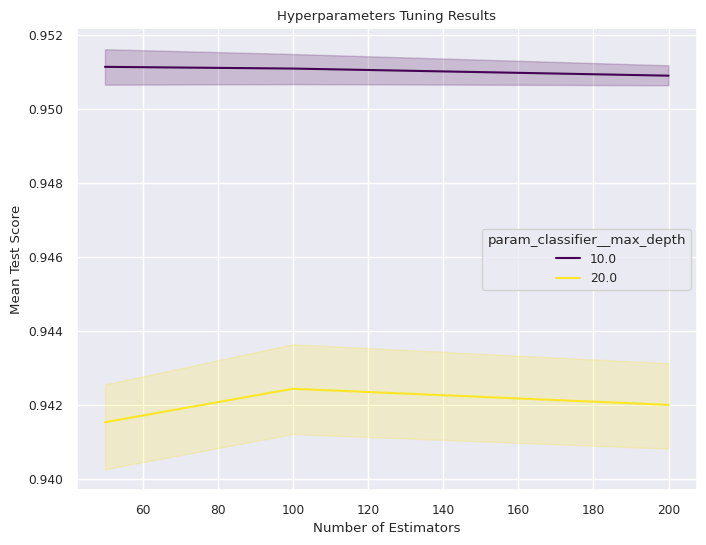

In [220]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=results_df, x='param_classifier__n_estimators', y='mean_test_score',
             hue='param_classifier__max_depth', palette='viridis')
plt.title('Hyperparameters Tuning Results')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')
plt.show()

# y='mean_test_score'
# Along the Y axis is the average accuracy (mean_test_score) during validation.
# That is, how well the model works with each set of parameters.

# x='param_classifier__n_estimators'
# Along the X axis is how many trees (n_estimators) are in the forest.
# This is the parameter we selected in Grid Search.

# hue='param_classifier__max_depth'
# Each line on the graph is its own tree depth value (max_depth).
# For example, one line is for depth 5, another is for 10, etc.

# Predict and evaluate

In [ ]:
# Precision TP / (TP + FP)- The model said that 10 people are sick, but only 7 are actually sick → accuracy = 70%.
# Recall TP / (TP + FN) - For example: If 10 people are sick, and the model found only 7 → completeness = 70%.
# F1-score 2 * (P * R) / (P + R) - Balance between Precision and Recall. It's good when both precision and recall are important.
# support - it is simply the number of true examples of each class in the test data.

# TP (True Positive) - the model said "sick", and he really is sick ✅
# FP (False Positive) - the model said "sick", but he is healthy ❌
# FN (False Negative) - the model said "healthy", but he is sick ❌
# TN (True Negative) - the model said "healthy", and he is healthy ✅

In [224]:
# Predict on the test set using the best model
y_pred = grid_search.predict(X_test)

# Evaluate the model
print("Model accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# accuracy_score - Percentage of correct predictions out of all.
# Example:
# Out of 100 patients, the model correctly identified 90 → accuracy = 0.90 (90%)
# TP + TN / TP + TN + FP + FN

# classification_report - Detailed report with metrics:
# Precision (accuracy)
# Recall (recall)
# F1-score (average between them)
# Support (number of examples per class)
#
# confusion_matrix - A table that shows:
# How many were correctly predicted
# How many were incorrect (for example, patients were called healthy and vice versa)

Model accuracy:  0.9482471652969936
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     17525
           1       0.68      0.80      0.73      1701

    accuracy                           0.95     19226
   macro avg       0.83      0.88      0.85     19226
weighted avg       0.95      0.95      0.95     19226



## Plot confusion matrix

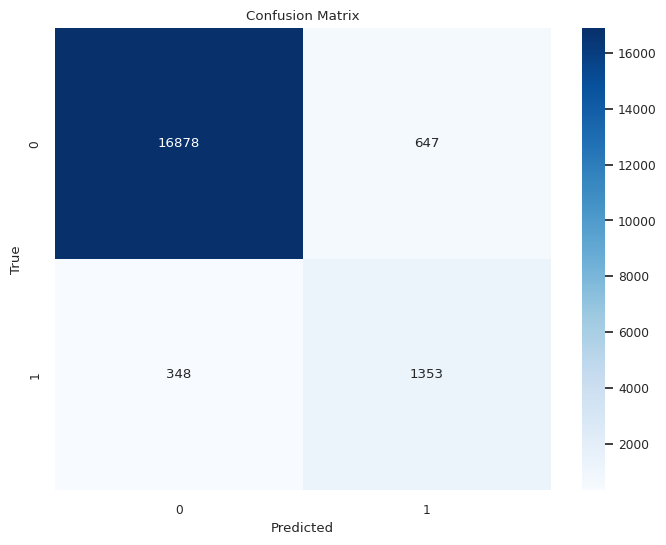

In [227]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
# Predicted
#  0   1
# [TN FP]
# [FN TP]

## Feature Importance

                        Feature  Importance
2                   HbA1c_level    0.421766
3           blood_glucose_level    0.328726
0                           age    0.110530
1                           BMI    0.080593
4                  hypertension    0.027252
5                 heart_disease    0.020254
10  smoking_history_pass_smoker    0.003379
9    smoking_history_non-smoker    0.003243
7                   gender_Male    0.001796
6                 gender_Female    0.001711
8       smoking_history_current    0.000750


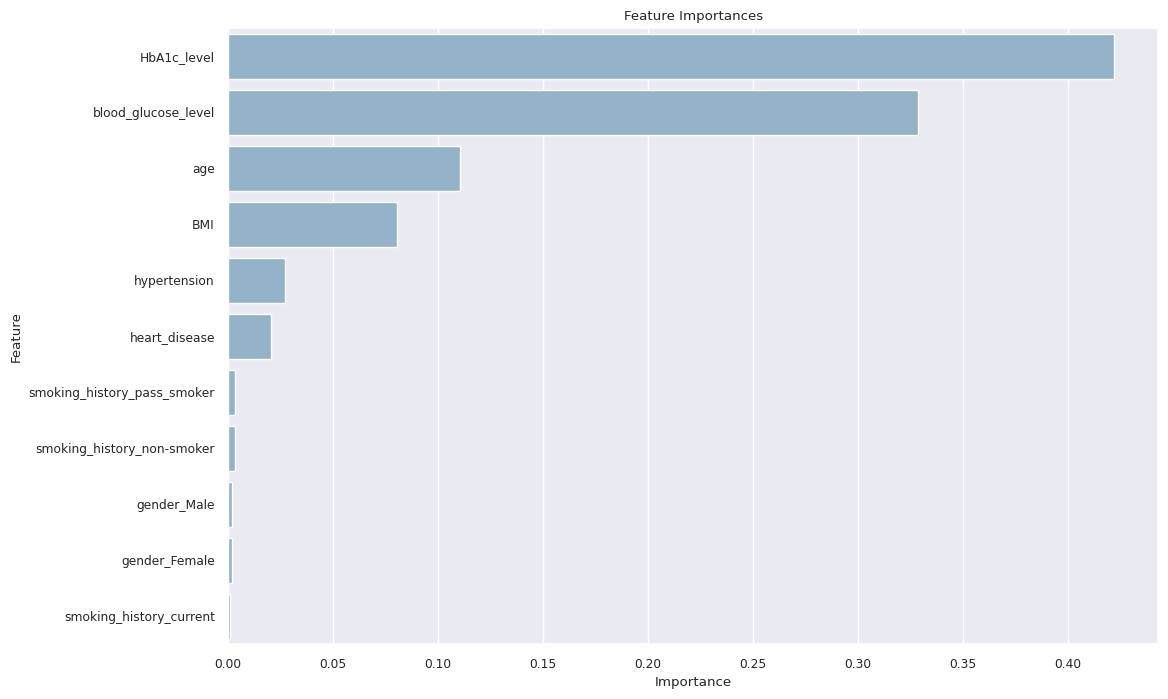

In [228]:
# After fitting the model, we input feature names
onehot_columns = list(grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(['gender', 'smoking_history'])) # We transform text features (gender, smoking history) into numbers (0/1) and get their names.

# Then we add the numeric feature names
feature_names = ['age', 'BMI', 'HbA1c_level', 'blood_glucose_level', 'hypertension', 'heart_disease'] + onehot_columns

# And now let's get the feature importances
importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_

# Create a dataframe for feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the dataframe by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Print the feature importances
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()